# 08. XGBoost Modeling 

운전조건(op1, op2)을 사용하여 XGBoost 회귀 모델을 학습하고 추론합니다.

In [24]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_csv('../data/processed_train.csv')

features = ['op1', 'op2', 's2', 's3', 's4','s5','s6','s7', 's8', 's9',
            's11', 's12', 's13', 's14', 's15','s16','s17', 's20','s21']
target = 'RUL_clipped'

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
joblib.dump(scaler, '../models/xgb_scaler.pkl')

['../models/xgb_scaler.pkl']

In [14]:
last_df = df.sort_values('time').groupby('unit').tail(1)
X = df[features]
y = df['RUL_clipped']


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

MAE: 13.31, RMSE: 18.60


In [17]:
y_full_pred = model.predict(last_df[features])
df_xgb_pred = pd.DataFrame({
    'unit': last_df['unit'].values,
    'RUL_pred': y_full_pred
})
df_xgb_pred.to_csv('../models/xgb_pred.csv', index=False)

In [18]:
print(y_train.mean(), y_train.min(), y_train.max())  # 학습 target 범위
print(model.feature_importances_)  # 피처가 의미 있게 쓰였는지

86.51678380998545 0 125
[0.00190418 0.00222486 0.01237682 0.00826477 0.18156688 0.
 0.00377497 0.04101531 0.0105732  0.1014752  0.4534736  0.07680513
 0.01379445 0.01770745 0.02199767 0.         0.020281   0.02029272
 0.01247185]


In [19]:
print(y_full_pred[:10]) 

[1.8924632 2.7068264 3.7473311 2.6334178 4.2829237 2.7946162 2.1265273
 4.1448174 2.1107948 7.0437775]


In [20]:
print(df['RUL_clipped'].describe())
print(df.groupby('unit')['time'].max().head())
print(df[['unit', 'time', 'RUL', 'RUL_clipped']])

count    20631.000000
mean        86.829286
std         41.673699
min          0.000000
25%         51.000000
50%        103.000000
75%        125.000000
max        125.000000
Name: RUL_clipped, dtype: float64
unit
1    192
2    287
3    179
4    189
5    269
Name: time, dtype: int64
       unit  time  RUL  RUL_clipped
0         1     1  191          125
1         1     2  190          125
2         1     3  189          125
3         1     4  188          125
4         1     5  187          125
...     ...   ...  ...          ...
20626   100   196    4            4
20627   100   197    3            3
20628   100   198    2            2
20629   100   199    1            1
20630   100   200    0            0

[20631 rows x 4 columns]


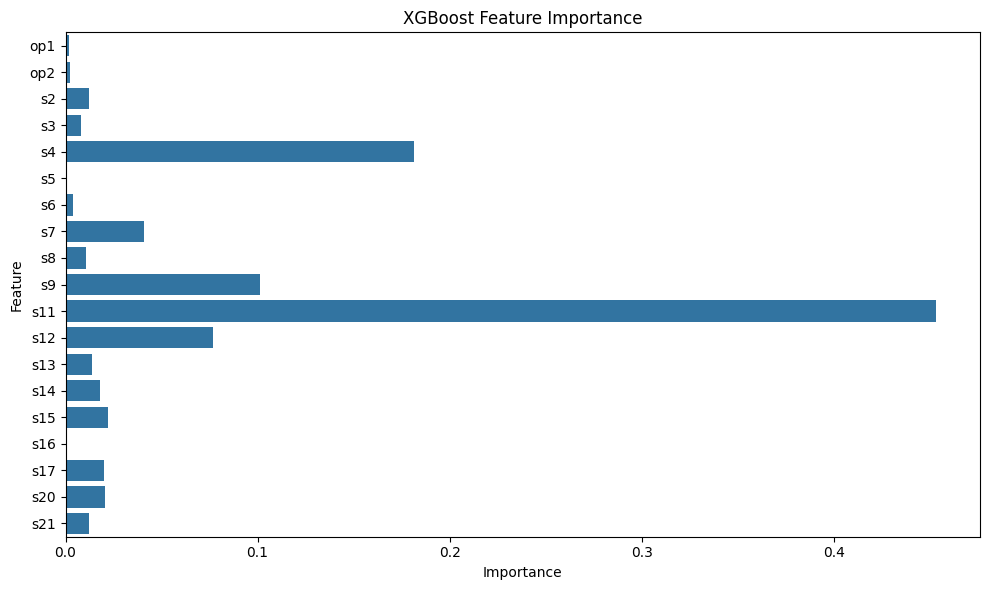

In [28]:
# 📊 Feature Importance 시각화
plt.figure(figsize=(10, 6))
importance = model.feature_importances_
sns.barplot(x=importance, y=features)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

- s11 센서가 가장 높은 중요도를 가지며, 모델 예측에 결정적으로 작용하고 있음.
- s4, s9, s12 또한 일부 기여하고 있음.
- 일부 센서 변수들(s5, s16 등)은 중요도가 거의 없음.

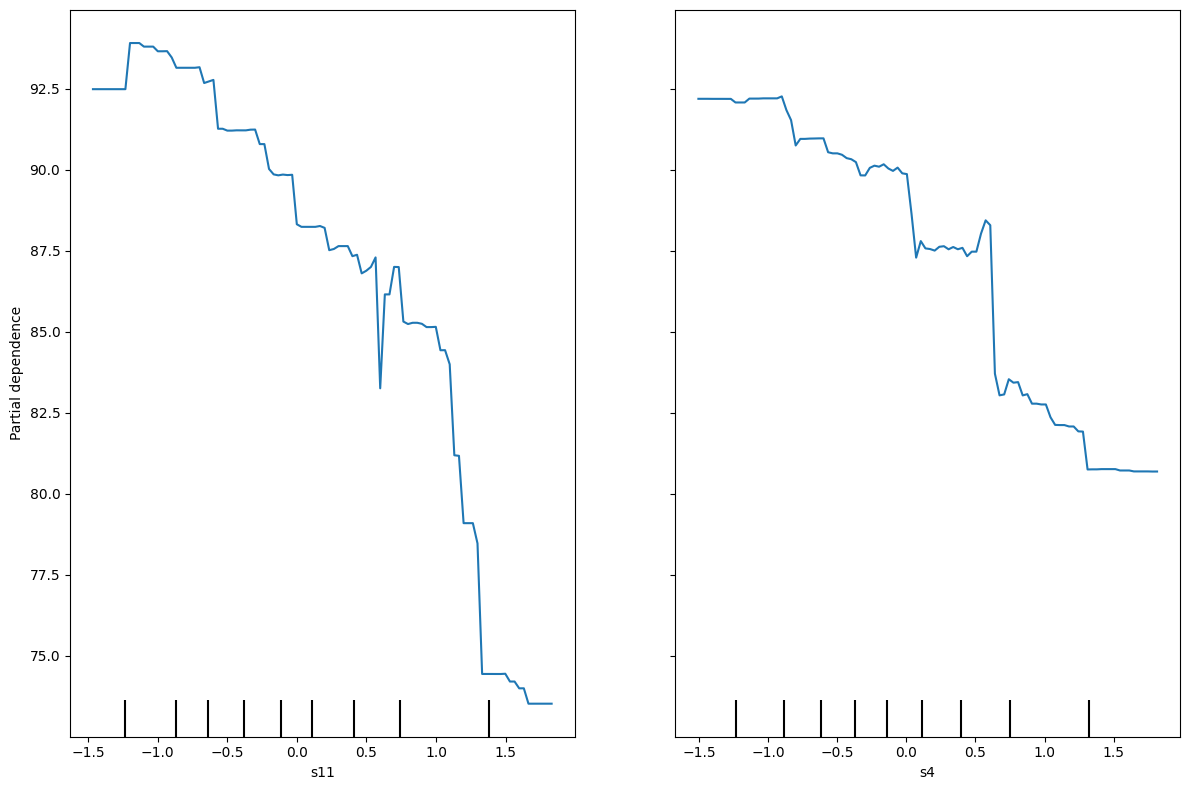

In [30]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# XGBoost 모델이 학습된 상태여야 함 (model)
# 사용한 feature 리스트는 동일하게 유지되어야 함 (features)

# 단일 피처에 대해 PDP 시각화 (예: s11)
features_to_plot = ['s11', 's4']  # 중요도가 높은 피처 선택

# PDP 시각화
fig, ax = plt.subplots(figsize=(12, 4 * len(features_to_plot)))
PartialDependenceDisplay.from_estimator(
    model,             # 학습된 XGBoost 모델
    X_val,             # Validation feature set (스케일링 완료된 상태여야 함)
    features_to_plot,  # 피처 이름 (문자열 리스트)
    grid_resolution=100,
    ax=ax
)
plt.tight_layout()
plt.show()

1. s11: 가장 영향력 높은 변수
	•	해석: s11 값이 증가할수록 예측된 RUL이 급격히 감소함.  
	•	구간별 민감도:  
	•	s11 < 0.5: 예측 RUL이 비교적 완만하게 감소.  
	•	s11 > 0.5: 예측 RUL이 비선형적으로 급락.  
	•	의미: 모델이 s11의 값에 과도하게 반응하고 있으며, 특정 임계값(0.5~1.0) 이상부터.RUL을 짧게 예측함.  
	•	위험성: s11의 노이즈나 외란이 있을 경우, 예측 안정성에 악영향 줄 수 있음.  

⸻
 
2. s4: 두 번째 중요 변수. 
	•	해석: s4 값이 증가하면 예측된 RUL이 점진적으로 감소.  
	•	구간별 민감도:  
	•	s4 < 0.5: RUL 변화 거의 없음.  
	•	s4 > 0.5: 예측 RUL이 일정한 기울기로 감소.  
	•	의미: s4는 비교적 안정적이고 선형적인 기여를 하고 있으며, 모델 의존도가 높은 편은 아님.  

## s11 데이터 분포 및 이상치 점검

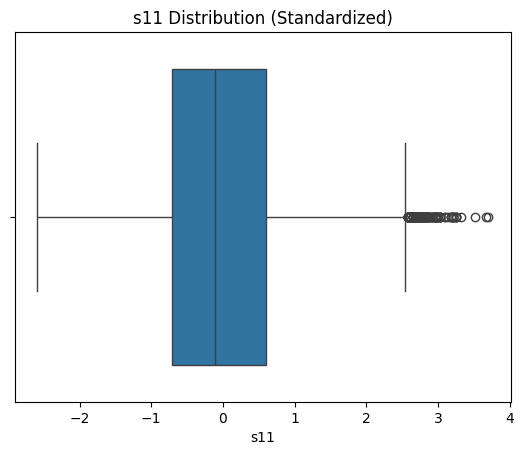

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['s11'])
plt.title("s11 Distribution (Standardized)")
plt.show()

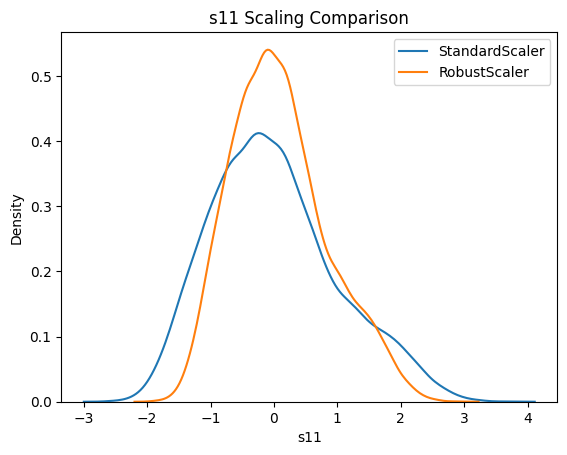

In [32]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# 기존 대비 Robust 방식 비교
robust_scaler = RobustScaler()
df['s11_robust'] = robust_scaler.fit_transform(df[['s11']])

sns.kdeplot(df['s11'], label='StandardScaler')
sns.kdeplot(df['s11_robust'], label='RobustScaler')
plt.legend()
plt.title('s11 Scaling Comparison')
plt.show()

In [33]:
features_drop_s11 = [f for f in features if f != 's11']
X_train_drop = X_train[features_drop_s11]
X_val_drop = X_val[features_drop_s11]

model_drop = XGBRegressor(random_state=42)
model_drop.fit(X_train_drop, y_train)
y_pred_drop = model_drop.predict(X_val_drop)

print("MAE (without s11):", mean_absolute_error(y_val, y_pred_drop))

MAE (without s11): 14.19942582092199


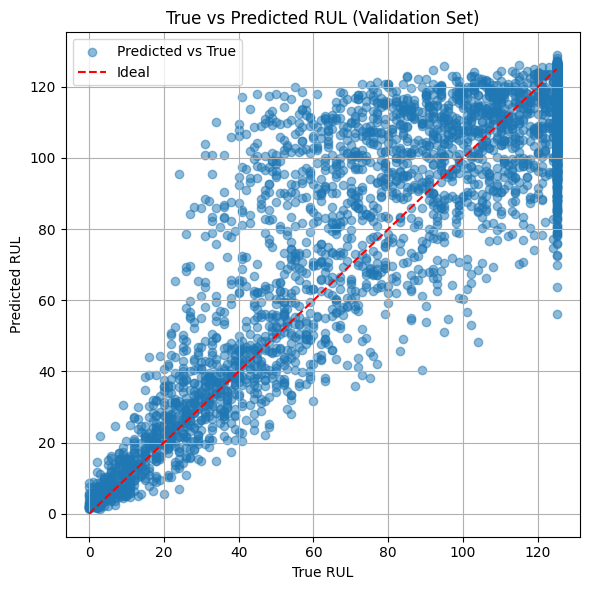

In [26]:
# 📉 True vs Predicted (검증셋)
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.5, label='Predicted vs True')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Ideal')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted RUL (Validation Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- 점들이 45도 기준선(이상적 예측선)을 중심으로 흩어져 있음.
- 다수는 기준선보다 아래에 위치 → 실제보다 더 낮은 RUL을 예측하는 경향.
- 특정 구간(중·고 RUL)에서는 과소 예측 편향이 있음.
- 모델이 전체적인 RUL 범위를 일정한 범위로 수렴시키는 경향 → 보수적 예측

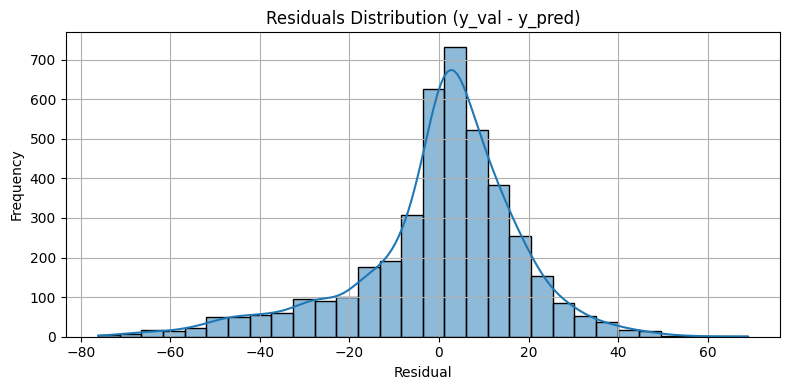

In [27]:
# 📉 Residuals Plot
residuals = y_val - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution (y_val - y_pred)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

- 잔차는 평균 0 부근을 중심으로 정규분포에 가까운 종 모양.
- 왼쪽 꼬리가 다소 두꺼움 → 음의 잔차가 많음 → 모델이 실제보다 RUL을 작게 예측하는 경우가 많음.
- 이 비대칭성은 시스템 잔여 수명 과소평가 가능성을 의미함.